In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from imblearn.under_sampling import RandomUnderSampler
from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings('ignore')

In [ ]:
path_to_dataset = 'datasets/'

In [ ]:
df_raw = pd.read_csv(path_to_dataset + 'Covid Data.csv')
# df_raw.head()
# df_raw = pd.read_csv("/Users/bytedance/Documents/Covid_Data.csv")

In [ ]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 21 columns):
 #   Column                Non-Null Count    Dtype 
---  ------                --------------    ----- 
 0   USMER                 1048575 non-null  int64 
 1   MEDICAL_UNIT          1048575 non-null  int64 
 2   SEX                   1048575 non-null  int64 
 3   PATIENT_TYPE          1048575 non-null  int64 
 4   DATE_DIED             1048575 non-null  object
 5   INTUBED               1048575 non-null  int64 
 6   PNEUMONIA             1048575 non-null  int64 
 7   AGE                   1048575 non-null  int64 
 8   PREGNANT              1048575 non-null  int64 
 9   DIABETES              1048575 non-null  int64 
 10  COPD                  1048575 non-null  int64 
 11  ASTHMA                1048575 non-null  int64 
 12  INMSUPR               1048575 non-null  int64 
 13  HIPERTENSION          1048575 non-null  int64 
 14  OTHER_DISEASE         1048575 non-null  int64 
 15

In [ ]:
df_raw.isnull().sum()

USMER                   0
MEDICAL_UNIT            0
SEX                     0
PATIENT_TYPE            0
DATE_DIED               0
INTUBED                 0
PNEUMONIA               0
AGE                     0
PREGNANT                0
DIABETES                0
COPD                    0
ASTHMA                  0
INMSUPR                 0
HIPERTENSION            0
OTHER_DISEASE           0
CARDIOVASCULAR          0
OBESITY                 0
RENAL_CHRONIC           0
TOBACCO                 0
CLASIFFICATION_FINAL    0
ICU                     0
dtype: int64

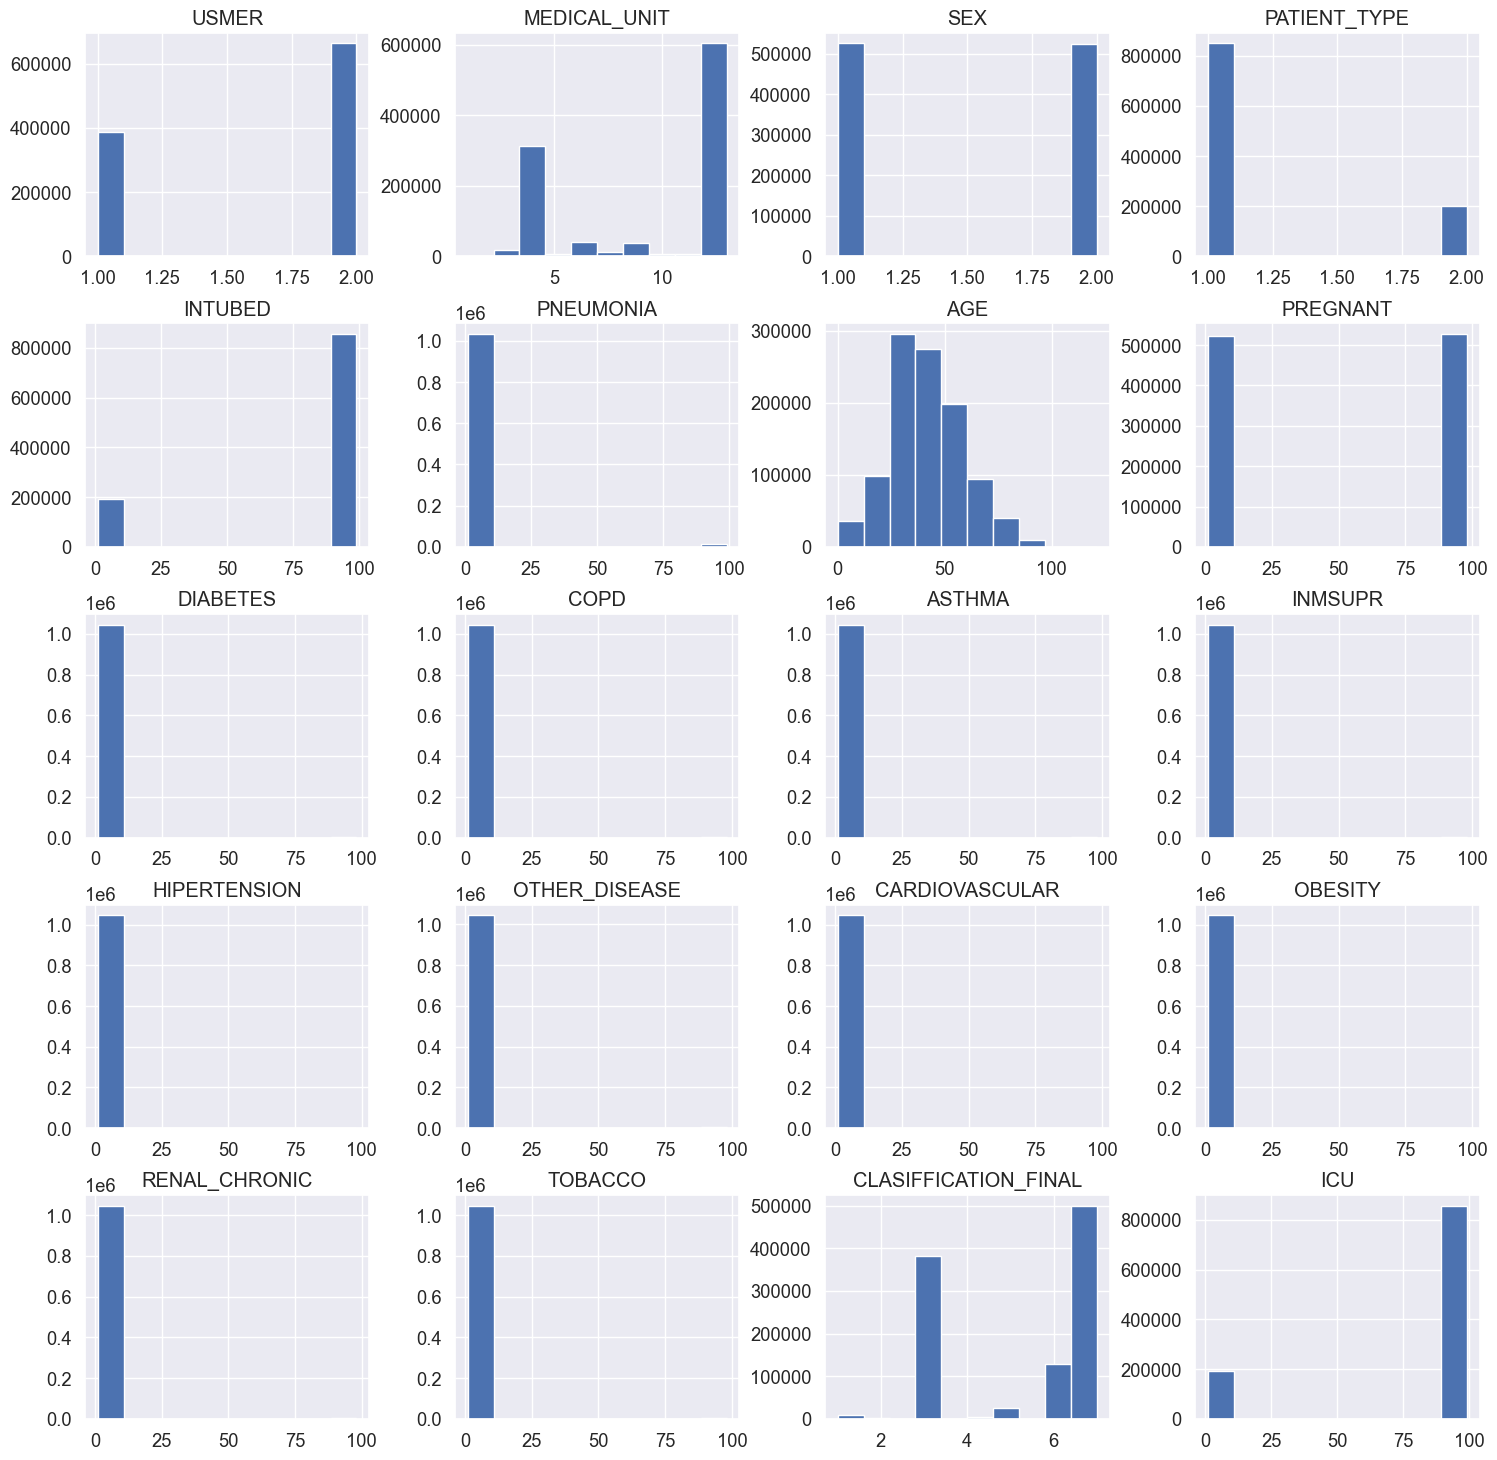

In [ ]:
df_raw.hist(bins = 10 , figsize= (18,18));

,USMER,value_count
0,2,662903
1,1,385672


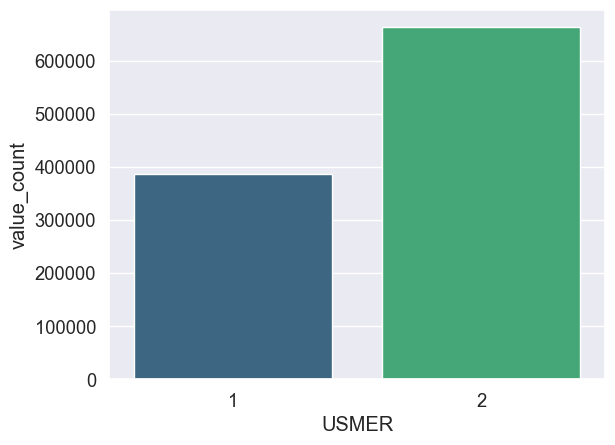

,MEDICAL_UNIT,value_count
0,12,602995
1,4,314405
2,6,40584
3,9,38116
4,3,19175
5,8,10399
6,10,7873
7,5,7244
8,11,5577
9,13,996


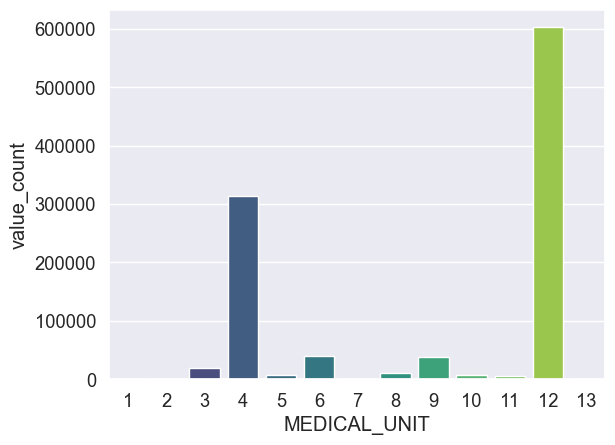

,SEX,value_count
0,1,525064
1,2,523511


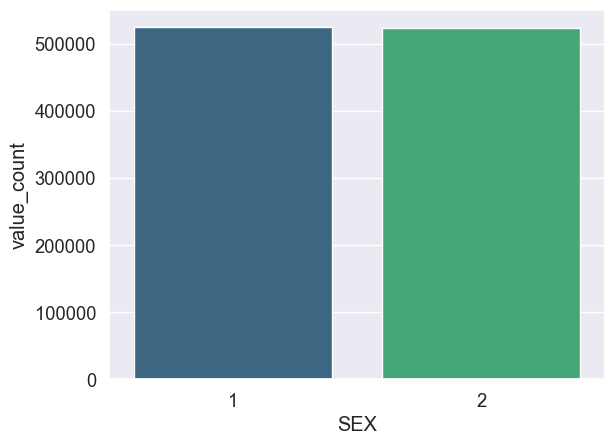

,PATIENT_TYPE,value_count
0,1,848544
1,2,200031


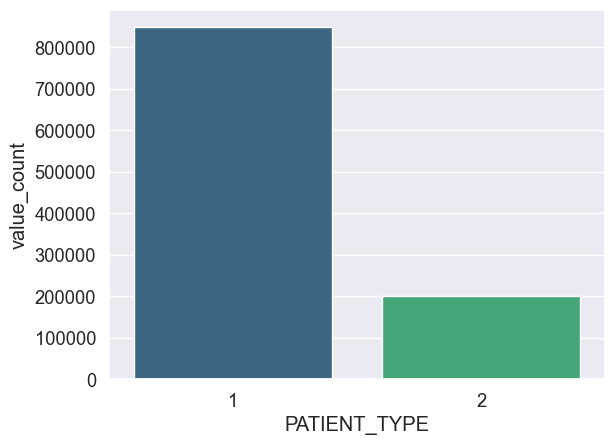

,INTUBED,value_count
0,97,848544
1,2,159050
2,1,33656
3,99,7325


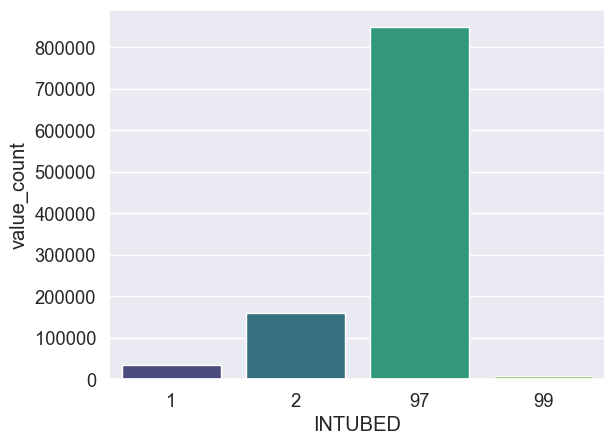

,PNEUMONIA,value_count
0,2,892534
1,1,140038
2,99,16003


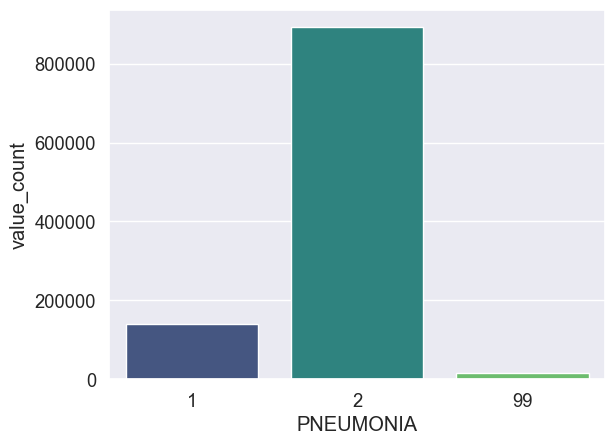

,AGE,value_count
0,30,27010
1,31,25927
2,28,25313
3,29,25134
4,34,24872
...,...,...
116,114,2
117,116,2
118,111,1
119,121,1


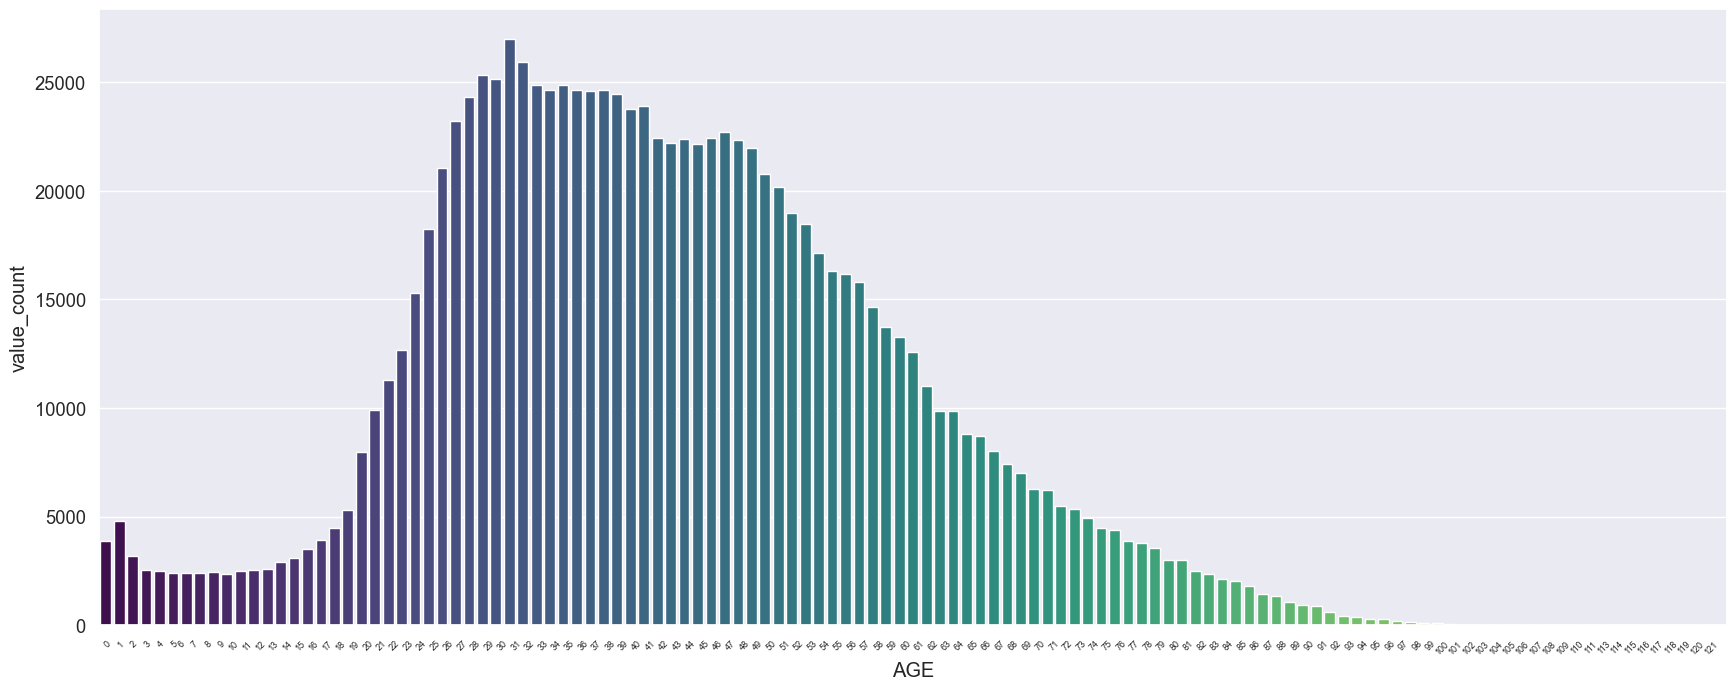

,PREGNANT,value_count
0,97,523511
1,2,513179
2,1,8131
3,98,3754


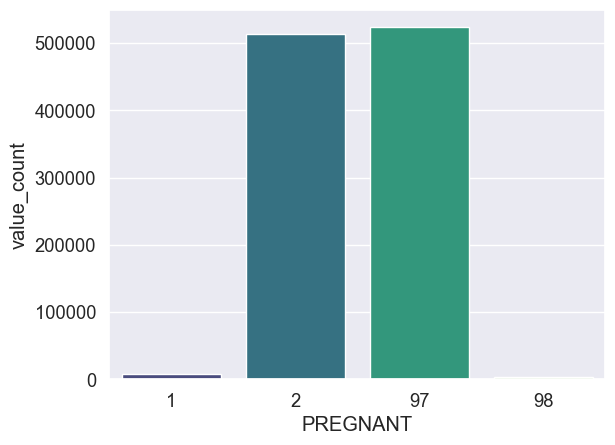

,DIABETES,value_count
0,2,920248
1,1,124989
2,98,3338


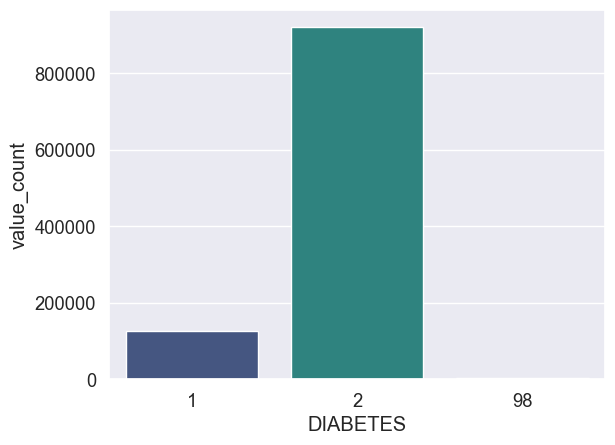

,COPD,value_count
0,2,1030510
1,1,15062
2,98,3003


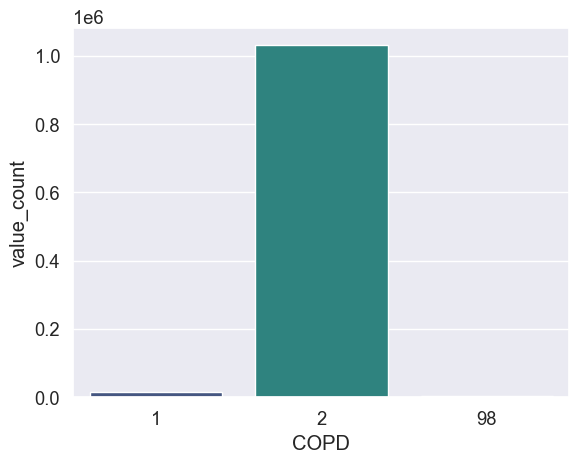

,ASTHMA,value_count
0,2,1014024
1,1,31572
2,98,2979


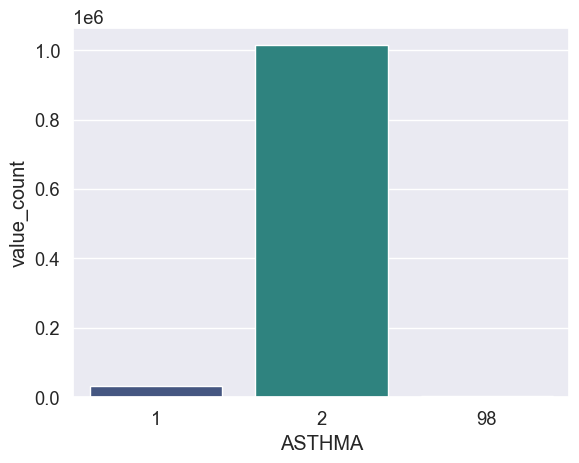

,INMSUPR,value_count
0,2,1031001
1,1,14170
2,98,3404


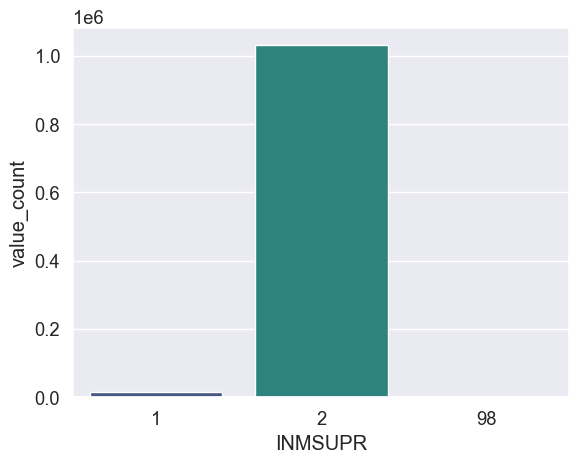

,HIPERTENSION,value_count
0,2,882742
1,1,162729
2,98,3104


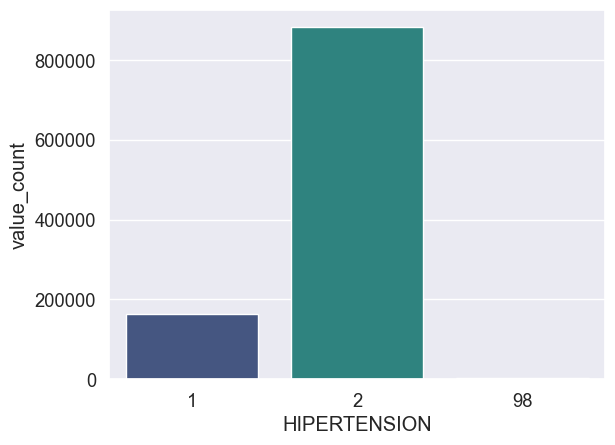

,OTHER_DISEASE,value_count
0,2,1015490
1,1,28040
2,98,5045


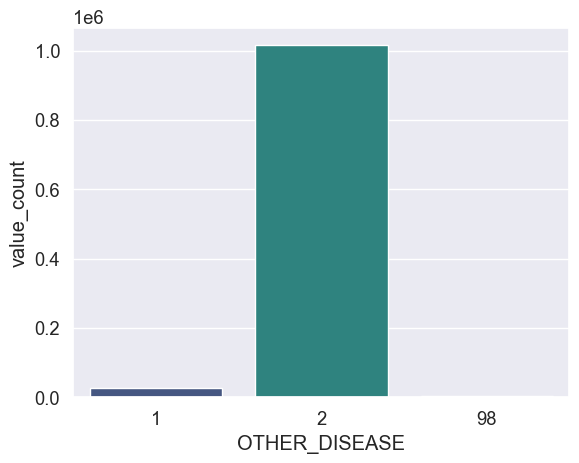

,CARDIOVASCULAR,value_count
0,2,1024730
1,1,20769
2,98,3076


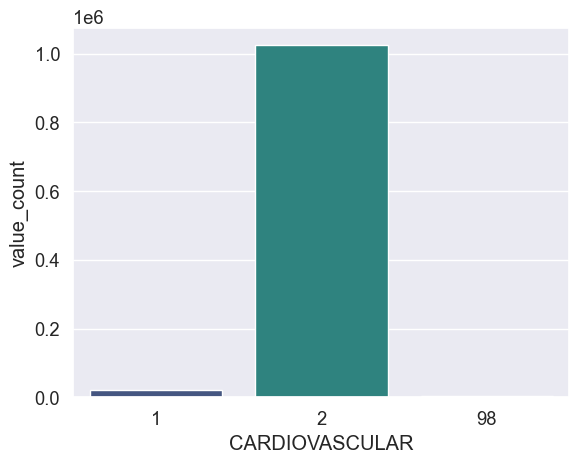

,OBESITY,value_count
0,2,885727
1,1,159816
2,98,3032


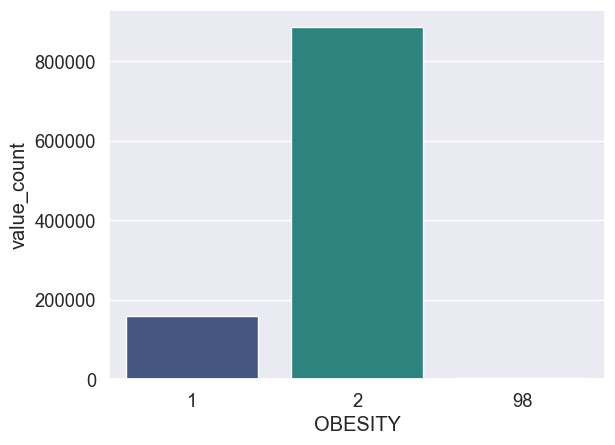

,RENAL_CHRONIC,value_count
0,2,1026665
1,1,18904
2,98,3006


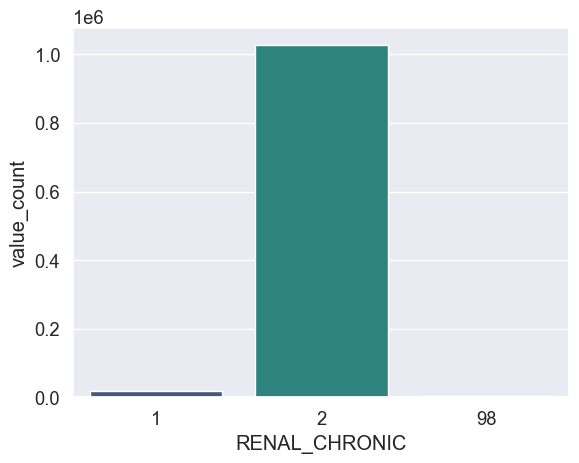

,TOBACCO,value_count
0,2,960979
1,1,84376
2,98,3220


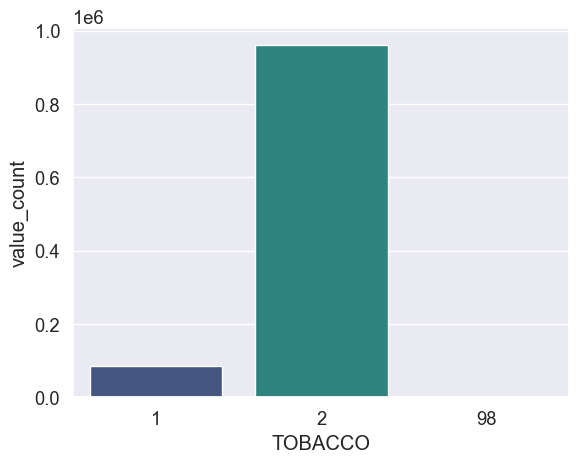

,CLASIFFICATION_FINAL,value_count
0,7,499250
1,3,381527
2,6,128133
3,5,26091
4,1,8601
5,4,3122
6,2,1851


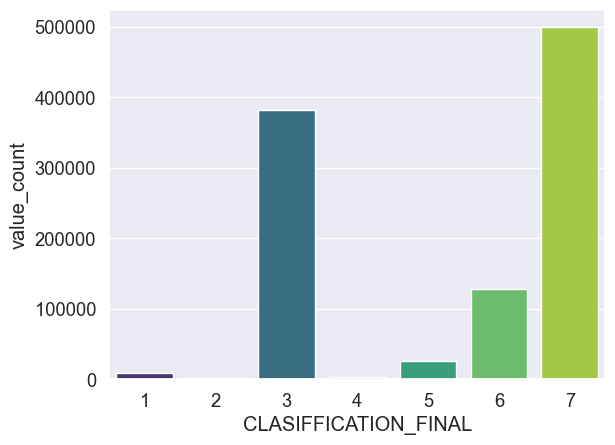

,ICU,value_count
0,97,848544
1,2,175685
2,1,16858
3,99,7488


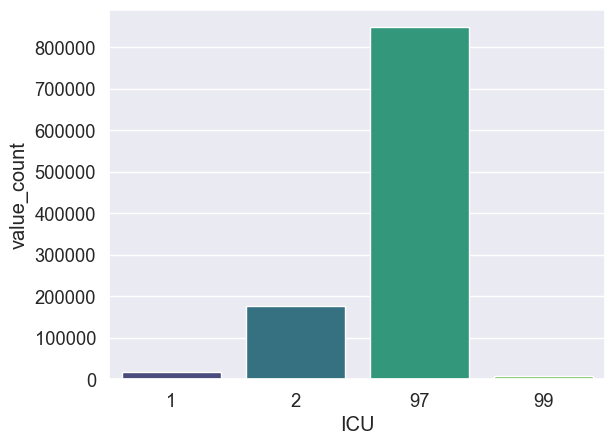

In [ ]:
for column in df_raw.columns:
    if column == 'DATE_DIED':
        continue
    df_column = pd.DataFrame(df_raw[column].value_counts().reset_index().values, columns=[column, 'value_count'])
    display(df_column)

    # From the above histogram, it can be seen that the age distribution is wider and needs to be displayed in more detail.
    if column == 'AGE':
        plt.figure(figsize=(21,8))
        plt.xticks(rotation=45, ha='right', rotation_mode='anchor', fontsize=6.5)
    sns.barplot(data=df_column, x=column, y='value_count', palette='viridis')
    plt.show()

Handle record where AGE is greater than 100

In [ ]:
df_raw.drop(df_raw[df_raw['AGE'] > 100].index, inplace=True)

Verification after dropping records with AGE greater than 100

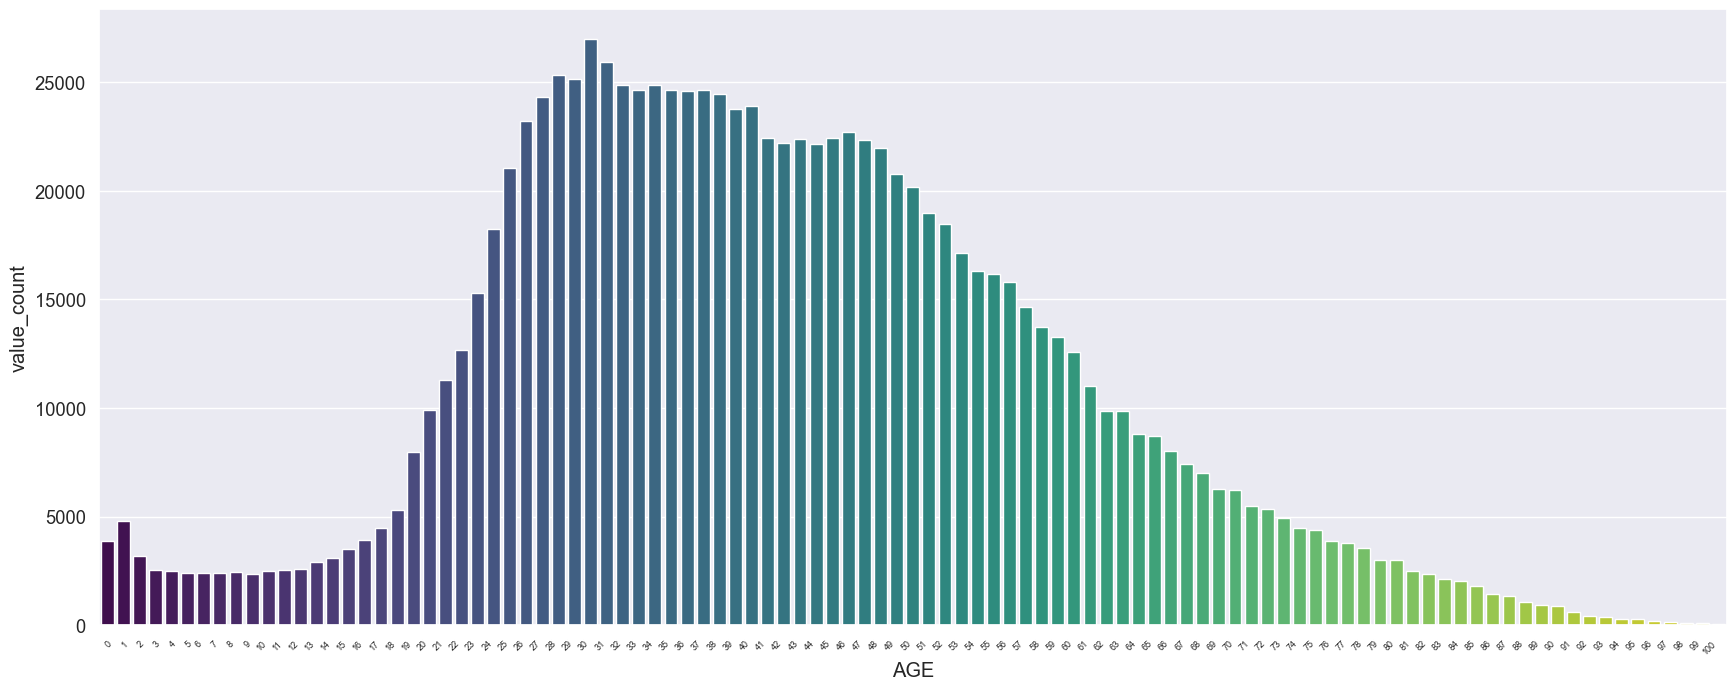

In [ ]:
df_age = pd.DataFrame(df_raw['AGE'].value_counts().reset_index().values, columns=['AGE', 'value_count'])

plt.figure(figsize=(21,8))
plt.xticks(rotation=45, ha='right', rotation_mode='anchor', fontsize=6.5)
sns.barplot(data=df_age, x='AGE', y='value_count', palette='viridis')
plt.show()

Fixing missing and conflicting data in PREGNANT column based on the following principles:
1. Men should not be pregnant
2. Women aged over 40 or less than 11 should not be pregnant

In [ ]:
df_raw.loc[(df_raw['SEX'] == 2), 'PREGNANT'] = 2
df_raw.loc[(df_raw['SEX'] == 1) & (df_raw['PREGNANT'] == 1) & ((df_raw['AGE'] >= 40) | (df_raw['AGE'] <= 11)), 'PREGNANT'] = 2
print(df_raw.shape[0])

1048437


Verification after fixing the raw data

,PREGNANT,value_count
2,98,3753


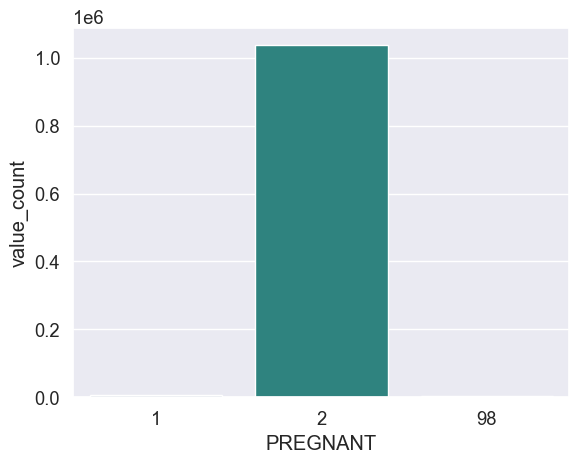

In [ ]:
df_pregnant = pd.DataFrame(df_raw['PREGNANT'].value_counts().reset_index().values, columns=['PREGNANT', 'value_count'])
display(df_pregnant[df_pregnant['PREGNANT'] == 98])

sns.barplot(data=df_pregnant, x='PREGNANT', y='value_count', palette='viridis')
plt.show()

Only 3753 records are now left with an unknown value for the PREGNANT column. These can be dropped.

In [ ]:
df_raw.drop(df_raw[df_raw['PREGNANT'] == 98].index, inplace=True)

Deletion of records where some other columns have unknown values

In [ ]:
delete_unknown_columns_list = ['PNEUMONIA', 'DIABETES', 'COPD', 'ASTHMA', 'INMSUPR', 'HIPERTENSION', 'OTHER_DISEASE', 'CARDIOVASCULAR', 'OBESITY', 'RENAL_CHRONIC', 'TOBACCO']

with pd.option_context('display.max_rows', 100, 'display.max_columns', 10):
    for column in delete_unknown_columns_list:
        print('Dropping record with unknown values for column: ', column)
        df_raw[column].replace([99, 98], 98, inplace=True)
        df_raw.drop(df_raw[df_raw[column] == 98].index, inplace=True)
        print(f'{df_raw.shape[0]} records remain after dropping records with unknown values for the {column} column')
        print()

Dropping record with unknown values for column:  PNEUMONIA
1029052 records remain after dropping records with unknown values for the PNEUMONIA column

Dropping record with unknown values for column:  DIABETES
1025913 records remain after dropping records with unknown values for the DIABETES column

Dropping record with unknown values for column:  COPD
1025559 records remain after dropping records with unknown values for the COPD column

Dropping record with unknown values for column:  ASTHMA
1025383 records remain after dropping records with unknown values for the ASTHMA column

Dropping record with unknown values for column:  INMSUPR
1024881 records remain after dropping records with unknown values for the INMSUPR column

Dropping record with unknown values for column:  HIPERTENSION
1024659 records remain after dropping records with unknown values for the HIPERTENSION column

Dropping record with unknown values for column:  OTHER_DISEASE
1022868 records remain after dropping records w

New column DIED created based on the following logic:
1. If the patient did not die (has DATE_DIED = '9999-99-99'), set this column to 0
2. If the patient died, set this column to 1

In [ ]:
df_raw['DIED'] = [0 if i == '9999-99-99' else 1 for i in df_raw['DATE_DIED']] # Set DIED to 0 if the patient did not die and to 1 if he/she died
df_raw.drop(columns='DATE_DIED', inplace=True)

New column COVID_POSITIVE created based on the following logic:
1. If the CLASIFFICATION_FINAL column has the values 1, 2 or 3, then set it to 1 (meaning that the patient is Covid Positive)
2. If the CLASIFFICATION_FINAL column has the values 4, 5, 6 or 7, then set it 0 (meaning that the patient is Covid Negative)

In [ ]:
df_raw['COVID_POSITIVE'] = [1 if i < 4 else 0 for i in df_raw['CLASIFFICATION_FINAL']]
df_raw.drop(columns=['CLASIFFICATION_FINAL'], inplace=True)

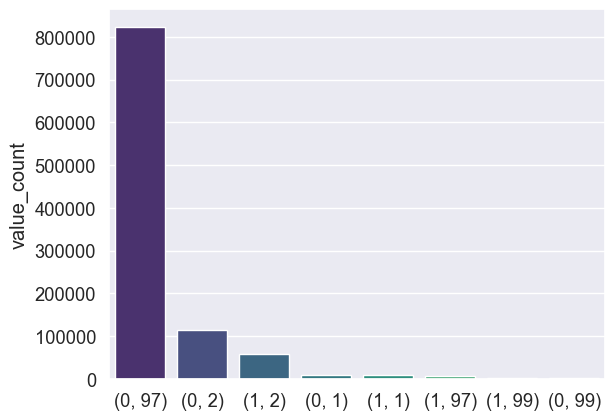

In [ ]:
df_died_icu = pd.DataFrame(df_raw[['DIED', 'ICU']].value_counts().reset_index().values, columns=['DIED', 'ICU', 'value_count']).set_index(['DIED', 'ICU'])

sns.barplot(data=df_died_icu, x=df_died_icu.index.map(str), y='value_count', palette='viridis')
plt.show()

Based on the above analysis, we see that most of the unknown values for the ICU column survived (as the value of the DIED column for those records is 0). This implies that the ICU column may not be very critical to this analysis of mortaility rates and we can drop it.

In [ ]:
df_raw.drop(columns=['ICU'], inplace=True)

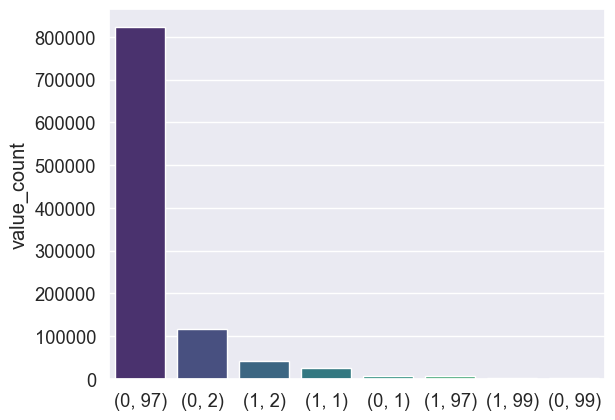

In [ ]:
df_died_intubed = pd.DataFrame(df_raw[['DIED', 'INTUBED']].value_counts().reset_index().values, columns=['DIED', 'INTUBED', 'value_count']).set_index(['DIED', 'INTUBED'])

sns.barplot(data=df_died_intubed, x=df_died_intubed.index.map(str), y='value_count', palette='viridis')
plt.show()

Based on the above analysis, we get the same result for the INTUBED column. So, it can also be dropped as it is not very critical to this analysis of mortality rates.

In [ ]:
df_raw.drop(columns=['INTUBED'], inplace=True)

In the raw dataset, 1 has been used to indicate "Yes" and 2 has been used to indicate "No". In order to follow the same convention, we change 2 to 0 in the whole dataset for these columns.

In [ ]:
non_zero_columns_list = ['USMER', 'SEX', 'PATIENT_TYPE', 'PNEUMONIA', 'PREGNANT', 'DIABETES', 'COPD', 'ASTHMA', 'INMSUPR', 'HIPERTENSION', 'OTHER_DISEASE', 'CARDIOVASCULAR', 'OBESITY', 'RENAL_CHRONIC', 'TOBACCO']
for column in non_zero_columns_list:
    df_raw[column].replace(2, 0, inplace=True)

In [ ]:
print(df_raw.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1021853 entries, 0 to 1048574
Data columns (total 19 columns):
 #   Column          Non-Null Count    Dtype
---  ------          --------------    -----
 0   USMER           1021853 non-null  int64
 1   MEDICAL_UNIT    1021853 non-null  int64
 2   SEX             1021853 non-null  int64
 3   PATIENT_TYPE    1021853 non-null  int64
 4   PNEUMONIA       1021853 non-null  int64
 5   AGE             1021853 non-null  int64
 6   PREGNANT        1021853 non-null  int64
 7   DIABETES        1021853 non-null  int64
 8   COPD            1021853 non-null  int64
 9   ASTHMA          1021853 non-null  int64
 10  INMSUPR         1021853 non-null  int64
 11  HIPERTENSION    1021853 non-null  int64
 12  OTHER_DISEASE   1021853 non-null  int64
 13  CARDIOVASCULAR  1021853 non-null  int64
 14  OBESITY         1021853 non-null  int64
 15  RENAL_CHRONIC   1021853 non-null  int64
 16  TOBACCO         1021853 non-null  int64
 17  DIED            1021853 non

We see that only 7.3% (74,646) of the records in the pre-processed dataset have the DIED column as 1 (patient is dead) while the remaining 92.7% (947,207) of the records have the DIED column as 0 (patient is not dead). This proves that the dataset is highly imbalanced. So, we perform training using undersampled data.

In [ ]:
df_raw['DIED'].value_counts()

0    947207
1     74646
Name: DIED, dtype: int64

In [ ]:
from sklearn.preprocessing import StandardScaler
standard_scaler = StandardScaler()
df_raw['AGE'] = standard_scaler.fit_transform(df_raw.loc[:,['AGE']])
df_raw['AGE'].head()

0    1.381043
1    1.799316
2    0.783511
3    0.664004
4    1.560303
Name: AGE, dtype: float64

<Axes: >

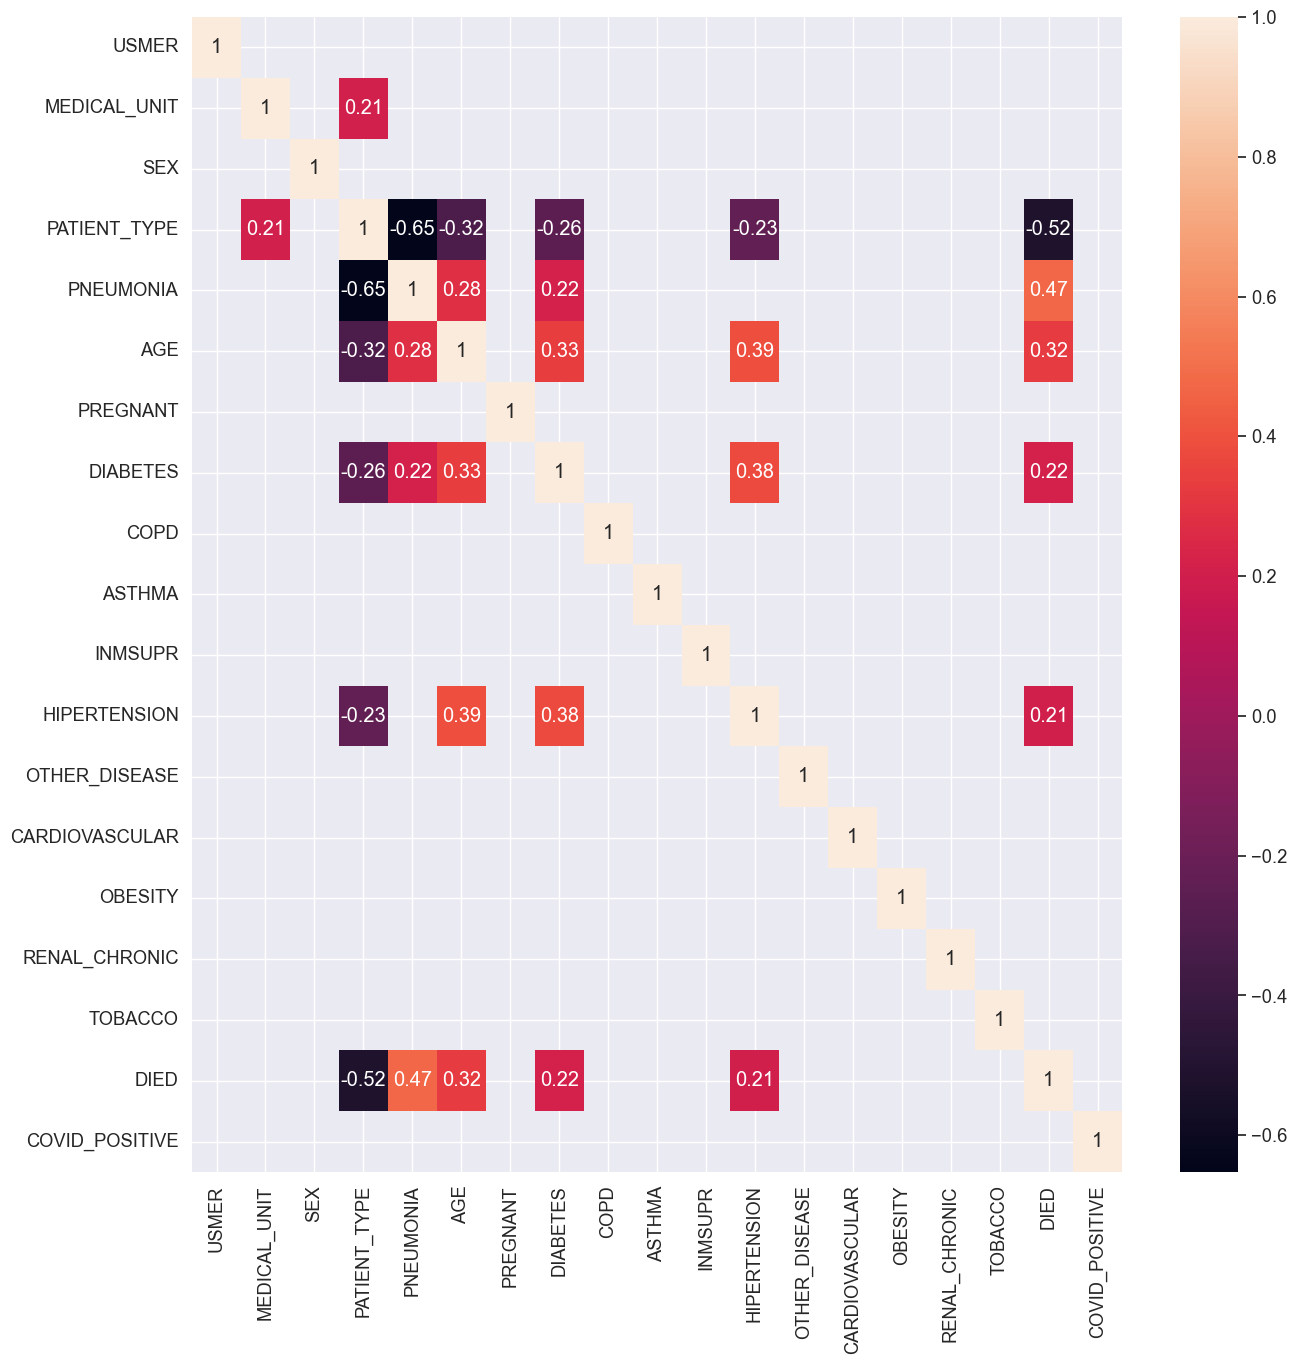

In [ ]:
corr=df_raw.corr()
plt.figure(figsize=(15,15))
sns.heatmap(c[(corr >= 0.2) | (corr <= -0.2)],annot=True)

In [ ]:
y = df_raw['DIED']
X = df_raw.drop(['DIED'], axis=1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
def generate_confusion_matrix(y_true, y_pred):
    cf_matrix = np.around(confusion_matrix(y_true=y_true, y_pred=y_pred, normalize='true'), decimals=3)
    cf_matrix_df = pd.DataFrame(cf_matrix, index=['0', '1'], columns=['0', '1'])

    plt.figure(figsize=(6, 4))
    sns.set(font_scale=1.2)
    sns.heatmap(cf_matrix_df, annot=True, cmap='Blues', fmt='g')
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')

    plt.show()

First we use default LogisticRegression on the whole training dataset to predict the mortality. From the generated Confusion Matrix, we see that this model is very good at detecting negatives (where the patient did not die) but it is worse than a random sampler at predicting the death of a patient correctly. This is due to the high imbalance in the dataset mentioned above.

Test metrics after training LogisticRegression on whole training dataset: 

              precision    recall  f1-score   support

           0       0.96      0.98      0.97    284383
           1       0.59      0.44      0.50     22173

    accuracy                           0.94    306556
   macro avg       0.77      0.71      0.73    306556
weighted avg       0.93      0.94      0.93    306556



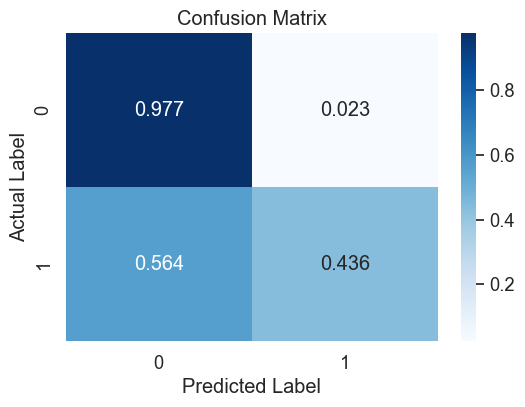

In [ ]:
lr = LogisticRegression(random_state=42, max_iter=5000, n_jobs=-1)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

print('Test metrics after training LogisticRegression on whole training dataset: \n')
print(classification_report(y_true=y_test, y_pred=y_pred))

generate_confusion_matrix(y_true=y_test, y_pred=y_pred)

In [ ]:
under_sampler = RandomUnderSampler(sampling_strategy=1, random_state=42)

X_train_undersampled, y_train_undersampled = under_sampler.fit_resample(X_train, y_train)

The undersampled data has an equal support for the target variable, as can be seen below. This undersampled will be used for training our models.

In [ ]:
y_train_undersampled.value_counts()

0    52473
1    52473
Name: DIED, dtype: int64

Set the below parameter to True if you want to perform Grid Search. As Grid Search runs for long, the parameter has been set to False.

In [ ]:
perform_grid_search = False

Hyperparameter Tuning using Grid Search:

In [ ]:
pipeline = Pipeline([
    ('classifier', None)
])

lr_param_grid = {
    'classifier__penalty': ['l1', 'l2', 'elasticnet']
    }

dt_param_grid = {
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__max_depth': range(5, 30, 5),
    'classifier__min_samples_leaf': range(1, 30, 5),
    'classifier__min_samples_split': range(200, 1001, 200),
    'classifier__max_features': range(5, 21, 5)
    }

rf_param_grid = {
    'classifier__min_samples_leaf': range(30, 71, 10),
    'classifier__min_samples_split': range(200, 1001, 200),
    'classifier__n_estimators': range(50, 81, 10)
    }

gb_param_grid = {
    'classifier__min_samples_leaf': range(30, 71, 10),
    'classifier__min_samples_split': range(200, 1001, 200),
    'classifier__n_estimators': range(50, 81, 10)
    }

mlp_param_grid = {
    'classifier__hidden_layer_sizes': [(25,), (50,), (100,), (25, 25), (50, 50)],
    'classifier__learning_rate': ['constant', 'adaptive']
    }

svc_param_grid = {
    'classifier__gamma': ['scale', 'auto'],
    'classifier__class_weight': [None, 'balanced']
    }

lgbm_param_grid = {
    'classifier__num_leaves': [31, 50, 100],
    'classifier__learning_rate': [0.05, 0.1, 0.2],
    'classifier__n_estimators': [100, 200, 500],
    'classifier__max_depth': [-1, 10, 20]
}

classifiers = {
    'logistic_regression': LogisticRegression(random_state=42, max_iter=5000, n_jobs=-1),
    'decision_tree': DecisionTreeClassifier(random_state=42),
    'random_forest': RandomForestClassifier(random_state=42, n_jobs=-1, warm_start=True, max_depth=20),
    'gradient_boost': GradientBoostingClassifier(random_state=42, warm_start=True, learning_rate=0.1, max_depth=8, max_features='sqrt', subsample=0.8),
    'mlp': MLPClassifier(random_state=42, max_iter=300, activation='logistic'),
    'svc': SVC(random_state=42),
    'lightgbm': LGBMClassifier(random_state=42)
    }

if perform_grid_search:
    for classifier_name, classifier in classifiers.items():
        if classifier_name == 'logistic_regression':
            param_grid = lr_param_grid
        elif classifier_name == 'decision_tree':
            param_grid = dt_param_grid
        elif classifier_name == 'random_forest':
            param_grid = rf_param_grid
        elif classifier_name == 'gradient_boost':
            param_grid = gb_param_grid
        elif classifier_name == 'mlp':
            param_grid = mlp_param_grid
        elif classifier_name == 'svc':
            param_grid = svc_param_grid
        elif classifier_name == 'lightgbm':
            param_grid = lgbm_param_grid

        pipeline.set_params(classifier=classifier)

        grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1', n_jobs=-1)
        grid_search.fit(X_train_undersampled, y_train_undersampled)

        print(f'\n\n{classifier_name}:')
        print(f'Best Parameters: {grid_search.best_params_} , Best Score: {grid_search.best_score_}')
else:
    print('Grid Search will not be performed as perform_grid_search = False...')

Grid Search will not be performed as perform_grid_search = False...


In [ ]:
def compute_model_predicted_values(classifier):
    classifier.fit(X=X_train_undersampled, y=y_train_undersampled)
    y_pred = classifier.predict(X=X_test)
    return y_pred

In [ ]:
def print_model_prediction_metrics(classifier_name, y_true, y_pred):
    print(f'Classifier: {classifier_name}\n')
    print(classification_report(y_true=y_true, y_pred=y_pred))
    print(f'ROC AUC score: {roc_auc_score(y_true=y_true, y_score=y_pred)}')

    print('------------------------------------\n')

Listing the best parameter configuration for each of the classifiers obtained through Hyperparameter Tuning using Grid Search:

In [ ]:
best_classifiers = {
    'logistic_regression': LogisticRegression(random_state=42, max_iter=5000, n_jobs=-1, penalty='l2'),
    'decision_tree': DecisionTreeClassifier(random_state=42, criterion='gini', max_depth=20, max_features=15, min_samples_leaf=6, min_samples_split=200),
    'random_forest': RandomForestClassifier(random_state=42, n_jobs=-1, warm_start=True, max_depth=20, min_samples_leaf=50, min_samples_split=200, n_estimators=80),
    'gradient_boost': GradientBoostingClassifier(random_state=42, warm_start=True, learning_rate=0.1, max_depth=8, max_features='sqrt', subsample=0.8, min_samples_leaf=50, min_samples_split=600, n_estimators=60),
    'mlp': MLPClassifier(random_state=42, max_iter=300, activation='logistic', hidden_layer_sizes=(50,), learning_rate='constant'),
    'svc': SVC(random_state=42, class_weight=None, gamma='auto'),
    'lightgbm': LGBMClassifier(random_state=42,  num_leaves=31,  learning_rate=0.1,  n_estimators=100,   max_depth=-1)
}

Evaluation of the best estimator classifiers against the test dataset:

Classifier: logistic_regression

              precision    recall  f1-score   support

           0       0.99      0.89      0.94    284383
           1       0.40      0.92      0.55     22173

    accuracy                           0.89    306556
   macro avg       0.70      0.90      0.75    306556
weighted avg       0.95      0.89      0.91    306556

ROC AUC score: 0.9048295470280414
------------------------------------



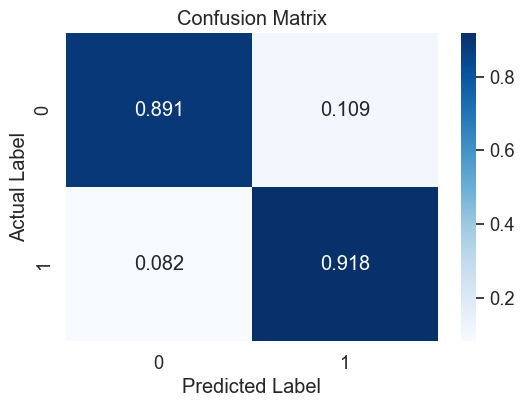

Classifier: decision_tree

              precision    recall  f1-score   support

           0       1.00      0.88      0.93    284383
           1       0.38      0.95      0.54     22173

    accuracy                           0.88    306556
   macro avg       0.69      0.91      0.74    306556
weighted avg       0.95      0.88      0.90    306556

ROC AUC score: 0.9128072531097512
------------------------------------



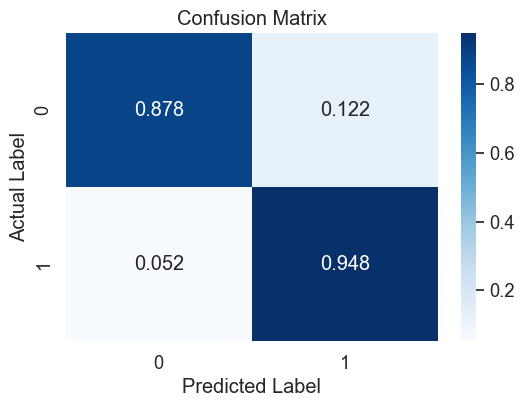

Classifier: random_forest

              precision    recall  f1-score   support

           0       1.00      0.87      0.93    284383
           1       0.37      0.95      0.53     22173

    accuracy                           0.88    306556
   macro avg       0.68      0.91      0.73    306556
weighted avg       0.95      0.88      0.90    306556

ROC AUC score: 0.9121737181359064
------------------------------------



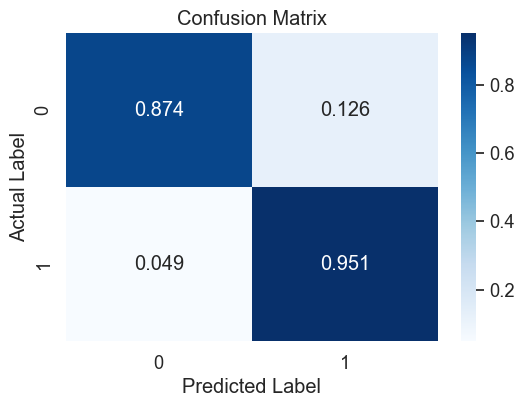

Classifier: gradient_boost

              precision    recall  f1-score   support

           0       1.00      0.88      0.93    284383
           1       0.38      0.95      0.54     22173

    accuracy                           0.88    306556
   macro avg       0.69      0.91      0.74    306556
weighted avg       0.95      0.88      0.91    306556

ROC AUC score: 0.914566698970193
------------------------------------



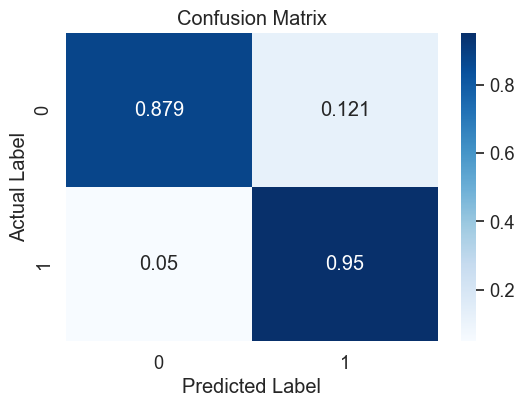

Classifier: mlp

              precision    recall  f1-score   support

           0       1.00      0.87      0.93    284383
           1       0.37      0.95      0.53     22173

    accuracy                           0.88    306556
   macro avg       0.68      0.91      0.73    306556
weighted avg       0.95      0.88      0.90    306556

ROC AUC score: 0.9130304086518835
------------------------------------



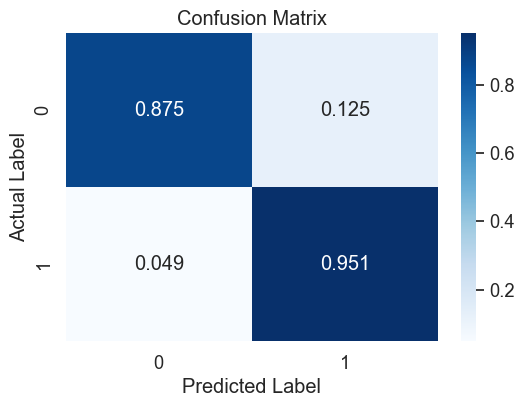

Classifier: svc

              precision    recall  f1-score   support

           0       1.00      0.86      0.92    284383
           1       0.35      0.96      0.52     22173

    accuracy                           0.87    306556
   macro avg       0.67      0.91      0.72    306556
weighted avg       0.95      0.87      0.90    306556

ROC AUC score: 0.9101178961478619
------------------------------------



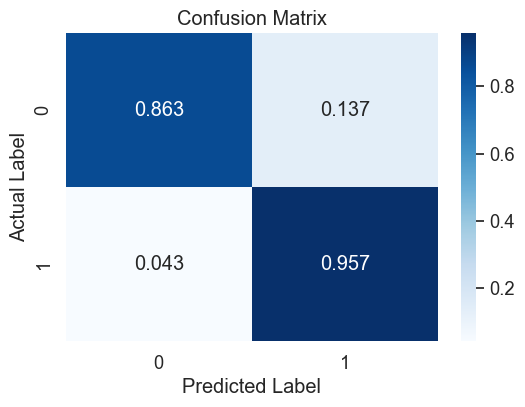

Classifier: lightgbm

              precision    recall  f1-score   support

           0       1.00      0.88      0.93    284383
           1       0.38      0.95      0.54     22173

    accuracy                           0.88    306556
   macro avg       0.69      0.92      0.74    306556
weighted avg       0.95      0.88      0.90    306556

ROC AUC score: 0.9153836094438307
------------------------------------



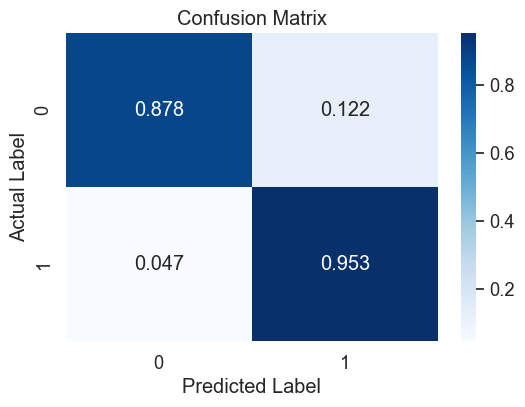

In [ ]:
for classifier_name, classifier in best_classifiers.items():
    y_pred = compute_model_predicted_values(classifier=classifier)
    print_model_prediction_metrics(classifier_name=classifier_name, y_true=y_test, y_pred=y_pred)
    generate_confusion_matrix(y_true=y_test, y_pred=y_pred)

#### Summary:
- Best Precision for Class 0: Logistic Regression and Random Forest.
- Best Recall for Class 1: Similar high performance across all models.
- Best F1-Score for Class 0: Logistic Regression.
- Best F1-Score for Class 1: Gradient Boost.
- Overall Accuracy: Similar across all models, with a slight edge for Logistic Regression.
- Best ROC AUC Score: LightGBM.

#### Conclusion:
**Balanced Performance:**
- **LightGBM** shows the most balanced performance across all metrics, making it a strong candidate for scenarios where both classes are equally important.

**Precision vs. Recall Trade-off**:
- If precision for class 0 is more critical, **Logistic Regression** or **Random Forest** might be preferred.
- For scenarios where capturing most positive cases (class 1) is crucial, all models perform similarly well.

**F1-Score Consideration**:
- **Logistic Regression** might be preferred for class 0, and **Gradient Boost** for class 1, due to their slightly higher F1-scores.

**Overall Effectiveness**:
- **LightGBM** stands out due to its highest ROC AUC score, indicating its superior capability in distinguishing between the two classes.


The highest ROC AUC score achieved by LightGBM can be attributed to its efficient handling of large and complex datasets and its advanced algorithmic features. LightGBM's gradient-based one-side sampling (GOSS) and exclusive feature bundling (EFB) enable it to focus more effectively on challenging cases and reduce feature dimensions without significant information loss. Additionally, its leaf-wise tree growth strategy allows for more precise model adjustments. These factors combined likely contributed to LightGBM's superior ability to distinguish between the two classes in the dataset, resulting in the highest ROC AUC score.


Relative Feature Importances influencing Covid-19 Mortality prediction based on tree-based classifiers:

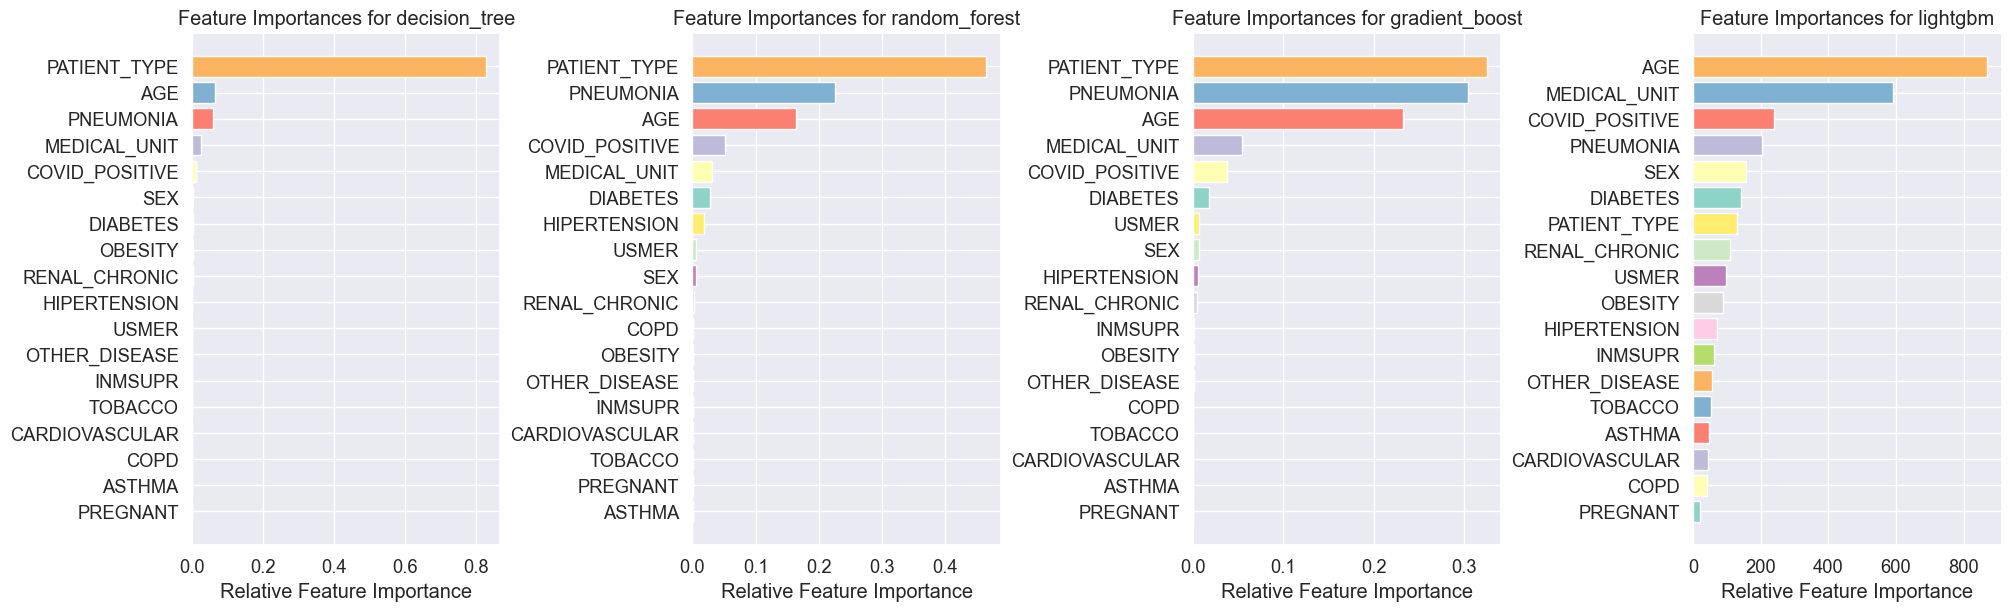

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(20, 6), constrained_layout=True)

count = 0
for classifier_name in ['decision_tree', 'random_forest', 'gradient_boost', 'lightgbm']:
    classifier = best_classifiers[classifier_name]
    classifier.fit(X_train_undersampled, y_train_undersampled)
    if classifier_name == 'lightgbm':
        features = X_train_undersampled.columns
    else:
        features = classifier.feature_names_in_
    importances = classifier.feature_importances_
    indices = np.argsort(importances)

    axes[count].barh(range(len(indices)), importances[indices], color=sns.color_palette('Set3'), align='center')
    axes[count].set_yticks(range(len(indices)), features[indices])
    axes[count].set_xlabel('Relative Feature Importance')
    axes[count].set_title(f'Feature Importances for {classifier_name}')

    count += 1

plt.show()

### Common Important Features:
- **'CARDIOVASCULAR'**, **'INMSUPR'**, and **'OTHER_DISEASE'** are consistently ranked as important across all models, indicating their significant role in prediction.

### Model Specific Variations:
- Each model's algorithm leads to different rankings and importance values. For instance, **'AGE'** is notably important in **LightGBM** but not as much in others.

The unique leaf-wise growth strategy, along with the GOSS and EFB techniques, allow LightGBM to potentially discover and utilize patterns related to 'AGE' more effectively than other models. This doesn't necessarily mean the other models undervalue 'AGE', but rather that LightGBM's approach to building trees and handling data might allow it to extract more predictive power from this particular feature in your dataset.